In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# I have experienced stability issues with float32.
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad

import neurax as nx
from neurax.channels import HHChannel
from neurax.synapses import GlutamateSynapse

### Setup

In [58]:
# Number of segments per branch.
nseg_per_branch = 8

# Stimulus.
i_delay = 3.0  # ms
i_amp = 0.05  # nA
i_dur = 2.0  # ms

# Duration and step size.
dt = 0.025  # ms
t_max = 50.0  # ms

In [59]:
time_vec = jnp.arange(0.0, t_max+dt, dt)

### Define compartment and branch

In [60]:
comp = nx.Compartment()
branch = nx.Branch([comp for _ in range(nseg_per_branch)])

In [61]:
branch.comp(0.0).record()

### Define cell

Below, we define the morphology. Each element of `parents` corresponds to one branch. A `-1` entry means that this branch does not have a parent. Alternatively, you could also load cells from SWC with 

```parents, lengths, endpoint_rads, start_rad = nx.utils.read_swc(fname, max_branch_len=300.0)```.

You can plot the SWC file with `nx.utils.plot_swc(fname, max_branch_len=300.0)`.

In [62]:
num_branches = 15
parents = jnp.asarray([-1, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6])
assert len(parents) == num_branches

In [63]:
cell = nx.Cell([branch for _ in range(num_branches)], parents=parents)

Cells can be visualized as follows:

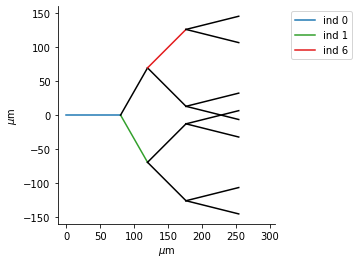

In [64]:
_ = nx.utils.plot_morph(cell, figsize=(4, 4), cols="k", highlight_branch_inds=[0, 1, 6])

### Define connectivity

In this case, two layers fully connected.

In [65]:
num_cells = 16

In [66]:
conn_builder = nx.ConnectivityBuilder([cell.total_nbranches for _ in range(num_cells)])

_ = np.random.seed(0)  # location of post synapse is random.
connectivities = [
    nx.Connectivity(
        GlutamateSynapse(),
        [
            *conn_builder.fc(np.arange(0, 5), np.arange(5, 15)),
            *conn_builder.fc(np.arange(5, 15), np.arange(15, 16)),
        ]
    ),
]

In [67]:
network = nx.Network([cell for _ in range(num_cells)], connectivities)

### Insert mechanisms

In [68]:
network.insert(HHChannel())

### Define stimuli and recordings

In [ ]:
for cell_ind in range(num_cells):
    network.cell(cell_ind).branch(0).comp(0.0).record()

stims = [
    nx.Stimulus(stim_ind, 0, 0.0, current=nx.step_current(i_delay, i_dur, i_amp, time_vec)) for stim_ind in range(5)
]

### Solve ODE

In [56]:
network.recordings

original_comp_index  original_branch_index  original_cell_index
7                       7                      0                    0
127                   127                     15                    1
247                   247                     30                    2
367                   367                     45                    3
487                   487                     60                    4
607                   607                     75                    5
727                   727                     90                    6
847                   847                    105                    7
967                   967                    120                    8
1087                 1087                    135                    9
1207                 1207                    150                   10
1327                 1327                    165                   11
1447                 1447                    180                   12
1567                 1567                    195                   13
1687                 1687                    210                   14
1807                 1807                    225                   15

In [57]:
%%time
s = nx.integrate(network, stimuli=stims, delta_t=dt)

AttributeError: 'DataFrame' object has no attribute 'comp_index'

### jit compilation

We can jit-compile the simulation in order to make it faster. The code below will be slow when run for the first time, but fast upon the second run.

In [17]:
def run_sim():
    return nx.integrate(network, stimuli=stims, recordings=recs, delta_t=dt)

jitted_run_sim = jit(run_sim)

In [20]:
%%time
s = jitted_run_sim()

CPU times: user 769 ms, sys: 4.02 ms, total: 773 ms
Wall time: 775 ms


### Visualize traces

In [ ]:
s.shape

(16, 2002)

In [39]:
time_vec.shape

(2001,)

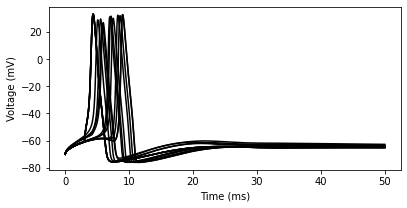

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6.3, 3))
for i in range(num_cells):
    _ = ax.plot(time_vec, s[i][:-1], c="k")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage (mV)")
plt.show()

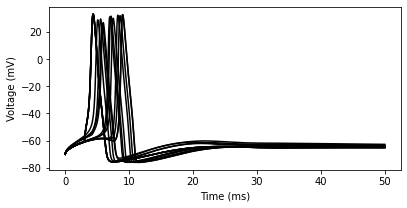

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6.3, 3))
for i in range(len(recs)):
    _ = ax.plot(time_vec, s[i][:-1], c="k")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Voltage (mV)")
plt.show()